# Detection of Spatial Signatures in Singapore

This notebook contains complete code required for a detection of spatial signatures in Singapore, limited by its administrative boundary.

This notebook relies on the `gds_env` as its main computational engine, which is deployed on a variety of servers and setups. This means that all the code produced in the project is reproducible under the containers provided in `gds_env`. This notebook uses `gds_py` flavour in a version `6.0`.

For more information on how to run `gds_env`, please visit:

> https://darribas.org/gds_env/

## Contents

- 1. Analysis of form
    - 1.1. Data retrieval
        - 1.1.1. Bulding footprints
        - 1.1.2. Street network
        - 1.1.3. Spatial barriers
    - 1.2. Data pre-processing
        - 1.2.1. Footprints checks and cleaning
        - 1.2.2. Barries checks and cleaning
    - 1.3. Generation of geographies
        - 1.3.1. Enclosures
        - 1.3.2. Enlclosed tessellation
    - 1.4. Morphometric analysis
        - 1.4.1. Primary morphometric characters
        - 1.4.2. Contextualisation
- 2. Analysis of function
    - 2.1. Eating establisments
    - 2.2. Supermarkets
    - 2.3. Land Use
    - 2.4. Parks
    - 2.5. Historical monuments
    - 2.6. Population
    - 2.7. NDVI
    - 2.8. Night lights
- 3. Cluster analysis
    - 3.1. Form
    - 3.2. Function
    - 3.3. Spatial Signatures
- 4. Figures

All packages and custom modules are imported below.

In [112]:
import pickle

import fiona
import geopandas as gpd
import libpysal
import momepy
import numpy as np
import osmnx as ox
import pandana
import pandas as pd
import rasterstats
import rioxarray
import scipy
import utils
import utils.consolidate
import utils.momepy
import xarray
from clustergram import Clustergram
from dask.distributed import Client, LocalCluster
from download import download
from rioxarray.merge import merge_arrays
from shapely.geometry import box, mapping
from shapely.ops import polygonize
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
from utils.tobler import area_max

Most of our data will be stored as geospatial parquet files, which is currently (Feb 2021) in its intial implementation, but we know that and can filter warnings.

In [4]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

First we specify a path to a folder for a data storage.

In [4]:
folder = "../../urbangrammar_samba/sp_sig_concept/singapore/"

## 1. Analysis of form

First step towards spatial signtures is an analysis of urban form to capture its patterns.

### 1.1. Data retrieval

All data used in the work are obtained from open access sources.

#### 1.1.1 Building footprints

Building footprints are obtained from OSM using OSMnx.

In [ ]:
%%time
footprints = ox.geometries_from_place("Singapore", tags={'building':True})
footprints_proj = ox.projection.project_gdf(footprints)
path = folder + 'footprints_osm.pq'
footprints_proj[['building', 'building:levels', 'geometry']].to_parquet(path)

#### 1.1.2 Street network

Street network is obtined from OSM using OSMnx, and custom tags.

We get a graph, project it, turn into undirected one and export to GeoDataFrame. Then we make sure `highway` parameter is string and can be saved to file.

In [5]:
%%time
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_place("Singapore", network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = folder + 'roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

CPU times: user 1min 50s, sys: 912 ms, total: 1min 51s
Wall time: 3min 39s


#### 1.1.3. Spatial barriers

Identification of enclosures should optimally contain variety of barriers, not only street networks. Therefore, we download railway and water geometry from OSM.

##### Water

In [ ]:
%%time
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_place("Singapore", tags)
path = folder + 'water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

##### Railway

Then we get railway and filter out proper geometry type (we want LineStrings representing railway tracks) and remove tunnels (those are not spatial barriers).

In [ ]:
tags = {'railway': True}
gdf = ox.geometries_from_place("Singapore", tags)
gdf = gdf[gdf.geom_type == 'LineString']
gdf = gdf[gdf.tunnel != 'yes']
path = folder + 'railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

### 1.2. Data pre-processing

Before we can analyse form using the data we just downloaded, we need to ensure that they are in a proper form.

#### 1.2.1. Footprints checks and cleaning

Let's start with building footprints.

In [13]:
buildings = gpd.read_parquet(folder + 'footprints_osm.pq')

OSM data tend to be messy, so we need to check validity and geometry types.

In [14]:
buildings.geom_type.value_counts()

Polygon         108661
Point               94
MultiPolygon        39
LineString           2
dtype: int64

We explode geometries and keep only polygons.

In [15]:
buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)
buildings = buildings[buildings.geom_type == 'Polygon']

We can then use `momepy.CheckTessellationInput()` class to check for potential issues which may arise during enclosed tessellation.

In [16]:
%time check = momepy.CheckTessellationInput(buildings)

/opt/conda/lib/python3.8/site-packages/momepy/utils.py:1003: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  shrink = shrink[~(shrink.is_empty | shrink.geometry.isna())]


Collapsed features  : 5
Split features      : 34
Overlapping features: 779
CPU times: user 10.5 s, sys: 229 ms, total: 10.7 s
Wall time: 10.4 s


In the ideal case, we should fix overlapping geometry. For the sake of examples, that is not necessary and we may drop them as well as buildings which would collapse.

In [17]:
buildings = buildings.drop(check.collapse.index.union(check.overlap.index))

In [18]:
buildings.shape

(108019, 3)

In [19]:
buildings.is_valid.all()

True

This results in 108 019 cleaned buildings. We will assign unique ID to each of them and save them to a file.

In [ ]:
buildings["uID"] = range(len(buildings))
%time buildings.to_parquet(folder + "buildings.pq")

#### 1.2.2. Barries checks and cleaning

Let's now check our barriers and close potential unwanted gaps to generate clean enclosures

In [6]:
roads = gpd.read_parquet(folder + "roads_osm.pq").to_crs(buildings.crs)

In [7]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [8]:
railway = gpd.read_parquet(folder + "railway_osm.pq").to_crs(buildings.crs)

In [9]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

Roads seems to be fine, similarly to railway. The only step we do is extension of railway lines to snap to roads.

In [10]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [11]:
water = gpd.read_parquet(folder + "water_osm.pq").to_crs(buildings.crs)

In [12]:
water.geom_type.value_counts()

Polygon         1066
LineString       189
MultiPolygon       2
Point              1
dtype: int64

We create LineString geometry out of polygons.

In [13]:
mask = water.geom_type.isin(["MultiPolygon", "Polygon"])

In [14]:
water.loc[mask, "geometry"] = water[mask].boundary

We then polygonize water to get the outlines of Singapore islands which can be used as a limit for enclosures.

In [16]:
limit = gpd.GeoSeries(polygonize(water.geometry.unary_union)).unary_union

### 1.3. Generation of geographies

Now we have to create geographies we will be using in the analysis. Enclosures and enclosed tessellation.

#### 1.3.1. Enclosures

Enclosures require spatial barriers, which are roads, water and railway (we use the extended one we did above), limited by sea.

In [17]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=gpd.GeoSeries([limit]), additional_barriers=[extended_railway, water])

CPU times: user 11.8 s, sys: 31.5 ms, total: 11.8 s
Wall time: 11.8 s


In [19]:
enclosures.is_valid.all()

True

In [20]:
enclosures.to_parquet(folder + "enclosures.pq")

#### 1.3.2. Enclosed tessellation

With enclosures and buildings, we can now create enclosed tessellation. To have a better control of dask cluster, we can create it directly (enclosed tessellation is a dask-parallelised function).

In [84]:
client = Client(LocalCluster(n_workers=16))
client

Client Scheduler: tcp://127.0.0.1:36241 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [85]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

/opt/conda/lib/python3.8/site-packages/distributed/worker.py:3373: UserWarning: Large object of size 36.81 MB detected in task graph: 
  ([         eID                                     ...  0.05, 'uID'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 1min 6s, sys: 12.1 s, total: 1min 18s
Wall time: 9min 31s


Now we can assign unique ID to each tessellation cell and save them. 

In [ ]:
tessellation = tess.tessellation
tessellation['tID'] = range(len(tessellation))
tessellation.to_parquet(folder + "tessellation.pq")

### 1.3. Morphometric analysis

Morpohmetric analysis first measures primary characters, which are then contextualised to capture the tendencies within the local context of each tessellation cell.

#### 1.3.1. Primary morphometric characters

For the analysis we need four input layer representing urban form - buildings, streets, enclosed tessellation and enclosures.

In [21]:
tess = gpd.read_parquet(folder + "tessellation.pq")
blg = gpd.read_parquet(folder + "buildings.pq")
streets = gpd.read_parquet(folder + 'roads_osm.pq')
enclosures = gpd.read_parquet(folder + "enclosures.pq")

In [23]:
tess.crs == blg.crs == streets.crs == enclosures.crs

True

In many cases, we will need to relate buildings to tessellation cells. the best way to ensure the proper linkage is to combine both GeoDataFrames into a single one with two named geometry columns. Remember that not every cell has assigned a building.

In [24]:
tess = tess.rename_geometry("tessellation").merge(blg[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [25]:
tess

,uID,tessellation,eID,tID,buildings
0,15894.0,"POLYGON ((375169.266 143445.969, 375215.555 14...",45,0,"POLYGON ((375488.721 143388.836, 375488.947 14..."
1,15895.0,"POLYGON ((375570.371 143269.939, 375570.488 14...",45,1,"POLYGON ((375601.423 143437.208, 375625.880 14..."
2,16484.0,"POLYGON ((375768.304 143392.659, 375757.980 14...",45,2,"POLYGON ((375756.182 143428.539, 375753.645 14..."
3,26213.0,"POLYGON ((375754.329 143271.830, 375752.662 14...",45,3,"POLYGON ((375780.585 143356.902, 375787.024 14..."
4,26214.0,"POLYGON ((375747.372 143332.482, 375749.257 14...",45,4,"POLYGON ((375697.450 143341.561, 375690.673 14..."
...,...,...,...,...,...
134917,NaN,"POLYGON ((383523.192 154933.560, 383510.203 15...",33861,134917,None
134918,NaN,"POLYGON ((380708.975 157411.368, 380707.697 15...",33862,134918,None
134919,NaN,"POLYGON ((353645.118 158537.917, 353608.695 15...",33863,134919,None
134920,NaN,"POLYGON ((394664.531 158413.756, 394665.472 15...",33864,134920,None


From the combined GeoDataFrame, we can create one with buildings as an active geometry, dropping rows which do not have any buildings.

In [26]:
blg = tess.set_geometry('buildings').dropna()

Now, we can measure morphometric characters. Refer to the [documentation of momepy](https://docs.momepy.org) for details on each one of them. Each result is assigned as a new column.

In [27]:
%time blg['sdbAre'] = momepy.Area(blg).series
%time blg['sdbPer'] = momepy.Perimeter(blg).series
%time blg['sdbCoA'] = momepy.CourtyardArea(blg, 'sdbAre').series

%time blg['ssbCCo'] = momepy.CircularCompactness(blg, 'sdbAre').series
%time blg['ssbCor'] = momepy.Corners(blg).series
%time blg['ssbSqu'] = momepy.Squareness(blg).series
%time blg['ssbERI'] = momepy.EquivalentRectangularIndex(blg, 'sdbAre', 'sdbPer').series
%time blg['ssbElo'] = momepy.Elongation(blg).series
%time cencon = momepy.CentroidCorners(blg)
blg['ssbCCM'] = cencon.mean
blg['ssbCCD'] = cencon.std

%time blg['stbOri'] = momepy.Orientation(blg).series
 
%time tess['stcOri'] = momepy.Orientation(tess).series

tess = tess.merge(blg[['tID', 'stbOri']], on='tID', how='left')

%time tess['stbCeA'] = (tess['stbOri'] - tess['stcOri']).abs()

%time tess['sdcLAL'] = momepy.LongestAxisLength(tess).series
%time tess['sdcAre'] = momepy.Area(tess).series
%time tess['sscCCo'] = momepy.CircularCompactness(tess, 'sdcAre').series
%time tess['sscERI'] = momepy.EquivalentRectangularIndex(tess, 'sdcAre').series

%time tess['sicCAR'] = tess.buildings.area / tess['sdcAre']
%time blg["mtbSWR"] = momepy.SharedWallsRatio(blg).series

CPU times: user 27.3 ms, sys: 300 µs, total: 27.6 ms
Wall time: 26.2 ms
CPU times: user 24.2 ms, sys: 0 ns, total: 24.2 ms
Wall time: 23.7 ms
CPU times: user 1.95 s, sys: 10.7 ms, total: 1.96 s
Wall time: 1.96 s


  1%|          | 736/109715 [00:00<00:14, 7357.17it/s]

CPU times: user 6.52 s, sys: 3.47 ms, total: 6.52 s
Wall time: 6.52 s


  7%|▋         | 7843/109715 [00:01<00:18, 5652.07it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:765: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
 19%|█▉        | 20782/109715 [00:03<00:13, 6654.19it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:766: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 452/109715 [00:00<00:24, 4515.63it/s]

CPU times: user 20.2 s, sys: 114 ms, total: 20.3 s
Wall time: 20.2 s


  7%|▋         | 7968/109715 [00:02<00:33, 3013.83it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:853: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
 19%|█▉        | 20968/109715 [00:05<00:22, 4004.62it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:854: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
 83%|████████▎ | 90977/109715 [00:25<00:05, 3155.58it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 109715/109715 [00:32<00:00, 3351.97it/s]


CPU times: user 32.7 s, sys: 288 ms, total: 33 s
Wall time: 32.7 s
CPU times: user 31.6 s, sys: 17.5 ms, total: 31.6 s
Wall time: 31.6 s


  0%|          | 339/109715 [00:00<00:32, 3387.70it/s]

CPU times: user 31.5 s, sys: 19.4 ms, total: 31.5 s
Wall time: 31.5 s


  7%|▋         | 7907/109715 [00:02<00:41, 2460.97it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1073: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
 19%|█▉        | 20892/109715 [00:06<00:27, 3206.67it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1074: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 342/109715 [00:00<00:31, 3418.96it/s]

CPU times: user 39.5 s, sys: 87.7 ms, total: 39.5 s
Wall time: 39.4 s


  0%|          | 83/134922 [00:00<02:42, 828.10it/s]

CPU times: user 35.4 s, sys: 99.8 ms, total: 35.5 s
Wall time: 35.5 s


100%|██████████| 134922/134922 [04:42<00:00, 477.24it/s] 


CPU times: user 4min 42s, sys: 534 ms, total: 4min 43s
Wall time: 4min 42s
CPU times: user 1.69 ms, sys: 16 µs, total: 1.7 ms
Wall time: 1.1 ms
CPU times: user 32.7 s, sys: 7.68 ms, total: 32.7 s
Wall time: 32.7 s
CPU times: user 139 ms, sys: 38 µs, total: 139 ms
Wall time: 139 ms
CPU times: user 34.5 s, sys: 19.8 ms, total: 34.5 s
Wall time: 34.5 s
CPU times: user 4min 33s, sys: 163 ms, total: 4min 33s
Wall time: 4min 33s
CPU times: user 23 ms, sys: 24 µs, total: 23 ms
Wall time: 21.6 ms
CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


Some of the characters require spatial weights matrices. We can generate Queen contiguity based on enclosed tessellation.

In [28]:
%time queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tess, ids="tID", geom_col='tessellation')
%time tess["mtbAli"] = momepy.Alignment(tess.set_geometry("buildings"), queen_1, "tID", "stbOri").series
%time tess["mtbNDi"] = utils.momepy.NeighborDistance(tess.set_geometry("buildings"), queen_1, "tID").series
%time tess["mtcWNe"] = momepy.Neighbors(tess, queen_1, "tID", weighted=True).series
%time tess["mdcAre"] = momepy.CoveredArea(tess, queen_1, "tID").series
%time blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blg, geom_col='buildings', silence_warnings=True)
 
%time blg["ldbPWL"] = momepy.PerimeterWall(blg, blg_q1).series
%time blg["libNCo"] = utils.momepy.Courtyards(blg, spatial_weights=blg_q1).series
%time queen_3 = momepy.sw_high(k=3, weights=queen_1)
%time tess['ltbIBD'] = utils.momepy.MeanInterbuildingDistance(tess.set_geometry('buildings'), queen_1, 'tID', queen_3).series

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 42 islands with ids: 122813, 122879, 125563, 134751, 134752, 134753, 134754, 134755, 134756, 134757, 134758, 134759, 134760, 134761, 134762, 134763, 134764, 134766, 134767, 134768, 134770, 134771, 134772, 134773, 134774, 134775, 134776, 134777, 134778, 134779, 134780, 134781, 134782, 134784, 134786, 134800, 134801, 134802, 134918, 134919, 134920, 134921.
  warnings.warn(message)
  0%|          | 243/134922 [00:00<00:55, 2421.76it/s]

CPU times: user 1min 59s, sys: 2.46 s, total: 2min 2s
Wall time: 2min 2s


  0%|          | 232/134922 [00:00<00:58, 2317.06it/s]

CPU times: user 56.8 s, sys: 2.42 s, total: 59.2 s
Wall time: 56.6 s


  7%|▋         | 9482/134922 [00:00<00:01, 94819.19it/s]

CPU times: user 49.1 s, sys: 120 ms, total: 49.2 s
Wall time: 49 s


  0%|          | 0/134922 [00:00<?, ?it/s]

CPU times: user 1.47 s, sys: 37 µs, total: 1.47 s
Wall time: 1.47 s


100%|██████████| 134922/134922 [00:22<00:00, 5976.90it/s]


CPU times: user 23.1 s, sys: 2.26 s, total: 25.3 s
Wall time: 22.8 s
CPU times: user 7.95 s, sys: 116 ms, total: 8.07 s
Wall time: 8.06 s


  0%|          | 161/109715 [00:00<01:08, 1608.21it/s]

CPU times: user 1min 28s, sys: 22.1 s, total: 1min 50s
Wall time: 1min 11s


100%|██████████| 109715/109715 [01:31<00:00, 1200.80it/s]


CPU times: user 1min 50s, sys: 20.9 s, total: 2min 11s
Wall time: 1min 31s
CPU times: user 13.1 s, sys: 431 ms, total: 13.6 s
Wall time: 13.6 s


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:308: UserWarning: {} islands in this weights matrix. Conversion to an adjacency list will drop these observations!
  warnings.warn(
  0%|          | 200/134922 [00:00<02:09, 1036.75it/s]

Computing mean interbuilding distances...


 76%|███████▌  | 102173/134922 [01:35<00:38, 842.07it/s] /home/jovyan/work/spatial_signatures_concept/code/utils/momepy.py:1099: RuntimeWarning: Mean of empty slice
  np.nanmean([x[-1] for x in list(sub.edges.data("weight"))])
100%|██████████| 134922/134922 [02:21<00:00, 951.76it/s] 


CPU times: user 2min 31s, sys: 1.19 s, total: 2min 32s
Wall time: 2min 30s


We also need to link tessellation cells to streets. We do it based on intersection. The following gives us the ratio if the tessellation intersects more than one cell. From these ratios we can get the primary link (the one which intersects the most). Since we need these links on both tessellation and buildings, we merge the result to `blg`. We also need to make sure that intially intereger index used as edgeID is preserved as an attribtue of streets in case we shuffle the data.


In [29]:
# get nid and primary nid here
%time links = utils.momepy.get_network_ratio(tess, streets)
tess[['edgeID_keys', 'edgeID_values']] = links
keys = tess.edgeID_values.apply(lambda a: np.argmax(a))
tess['edgeID_primary'] = [inds[i] for inds, i in zip(tess.edgeID_keys, keys)]
blg = blg.merge(tess[['tID', 'edgeID_primary']], on='tID', how='left')
streets['edgeID_primary'] = range(len(streets))

/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


CPU times: user 4min 49s, sys: 16.9 ms, total: 4min 49s
Wall time: 4min 49s


In [30]:
%time streets["sdsLen"] = momepy.Perimeter(streets).series
%time tess["stcSAl"] = momepy.StreetAlignment(tess, streets, "stcOri", "edgeID_primary").series
%time blg["stbSAl"] = momepy.StreetAlignment(blg, streets, "stbOri", "edgeID_primary").series

CPU times: user 6.43 ms, sys: 0 ns, total: 6.43 ms
Wall time: 5.38 ms
CPU times: user 2.99 s, sys: 0 ns, total: 2.99 s
Wall time: 2.99 s
CPU times: user 2.98 s, sys: 0 ns, total: 2.98 s
Wall time: 2.98 s


In [31]:
%time profile = momepy.StreetProfile(streets, blg, distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd

100%|██████████| 112298/112298 [44:39<00:00, 41.90it/s] 


CPU times: user 44min 41s, sys: 12.8 s, total: 44min 53s
Wall time: 44min 40s


In [32]:
%time streets["sssLin"] = momepy.Linearity(streets).series

CPU times: user 2.03 s, sys: 3.95 ms, total: 2.04 s
Wall time: 2.03 s


In [33]:
%%time 
# Area Covered by each edge
vals = {x:[] for x in range(len(streets))}
for i, keys in enumerate(tess.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(tess.sdcAre.iloc[inds].sum())
streets['sdsAre'] = area_sums

CPU times: user 10.1 s, sys: 3.36 ms, total: 10.1 s
Wall time: 10.1 s


In [34]:
%%time
# Buildings per meter
bpm = []
for inds, l in zip(vals.values(), streets.sdsLen):
    bpm.append(tess.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
streets['sisBpM'] = bpm

<timed exec>:4: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 32.5 s, sys: 66.7 ms, total: 32.6 s
Wall time: 32.5 s


Street network forms a graph. We can use this property to first define a context of each segment.

In [35]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = momepy.Reached(
    streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1, mode="count"
).series
streets["mdsAre"] = momepy.Reached(streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1,
                               mode="sum").series

100%|██████████| 112298/112298 [04:26<00:00, 422.02it/s]


And then to create graph representation and measure connectivity characters. The cell below creates `networkX.MultiGraph`, measures characters and returns two GeoDataFrames - original segments and nodes, accompanied with spatial weights.

In [36]:
%time graph = momepy.gdf_to_nx(streets)
 
print("node degree")
graph = momepy.node_degree(graph)
 
print("subgraph")
graph = momepy.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
print("cds length")
graph = momepy.cds_length(graph, radius=3, name="ldsCDL")
 
print("clustering")
graph = momepy.clustering(graph, name="xcnSCl")
 
print("mean_node_dist")
graph = momepy.mean_node_dist(graph, name="mtdMDi")
 
%time nodes, edges, sw = momepy.nx_to_gdf(graph, spatial_weights=True)

CPU times: user 14.2 s, sys: 0 ns, total: 14.2 s
Wall time: 14.2 s
node degree
subgraph


100%|██████████| 85852/85852 [01:26<00:00, 987.31it/s] 


cds length


100%|██████████| 85852/85852 [00:32<00:00, 2647.43it/s]


clustering
mean_node_dist


100%|██████████| 85852/85852 [00:01<00:00, 75126.95it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1466 disconnected components.
  warnings.warn(message)


CPU times: user 4.41 s, sys: 3.81 ms, total: 4.41 s
Wall time: 4.41 s


Weights and connections allow us to measure characters on a "subgraph" even without the networkX object.

In [37]:
%time edges_w3 = momepy.sw_high(k=3, gdf=edges)
%time edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
%time nodes_w5 = momepy.sw_high(k=5, weights=sw)
%time nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = momepy.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree"
).series

  1%|          | 1132/112298 [00:00<00:09, 11319.17it/s]

CPU times: user 9.74 s, sys: 196 ms, total: 9.93 s
Wall time: 9.93 s


100%|██████████| 112298/112298 [00:08<00:00, 13480.39it/s]


CPU times: user 8.63 s, sys: 807 ms, total: 9.44 s
Wall time: 8.37 s


  0%|          | 41/85852 [00:00<03:32, 402.95it/s]

CPU times: user 4.93 s, sys: 184 ms, total: 5.11 s
Wall time: 5.11 s


  0%|          | 33/85852 [00:00<04:27, 320.55it/s]

CPU times: user 3min 38s, sys: 308 ms, total: 3min 39s
Wall time: 3min 38s


100%|██████████| 85852/85852 [04:27<00:00, 321.07it/s]


Now we also include enclosures in the set.

In [38]:
enclosures["ldeAre"] = momepy.Area(enclosures).series
enclosures["ldePer"] = momepy.Perimeter(enclosures).series
enclosures["lseCCo"] = momepy.CircularCompactness(enclosures, "ldeAre").series
enclosures["lseERI"] = momepy.EquivalentRectangularIndex(enclosures, "ldeAre", "ldePer").series
enclosures["lseCWA"] = momepy.CompactnessWeightedAxis(enclosures, "ldeAre", "ldePer").series
enclosures["lteOri"] = momepy.Orientation(enclosures).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(enclosures, ids="eID")
 
inp, res = enclosures.sindex.query_bulk(enclosures.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
enclosures['neighbors'] = counts - 1
enclosures['lteWNB'] = enclosures['neighbors'] / enclosures['ldePer']

100%|██████████| 33866/33866 [00:16<00:00, 2005.34it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 47 islands with ids: 19982, 19983, 20067, 23041, 33683, 33684, 33685, 33686, 33687, 33689, 33691, 33692, 33693, 33694, 33695, 33696, 33697, 33698, 33699, 33700, 33703, 33704, 33705, 33708, 33709, 33710, 33711, 33712, 33713, 33714, 33715, 33716, 33717, 33718, 33719, 33720, 33721, 33724, 33727, 33728, 33743, 33744, 33745, 33862, 33863, 33864, 33865.
  warnings.warn(message)


In [39]:
# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = enclosures[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
enclosures['lieWCe'] = merged['tessellation'] / merged['ldeAre']

In [41]:
tess['ltcWRE'] = momepy.BlocksCount(tess, 'eID', queen_3, 'tID').series

100%|██████████| 134922/134922 [01:27<00:00, 1535.61it/s]


We will need to link data which are now on nodes to tessellation, so we need to get nearest network-based node ID.

In [49]:
# get node id
%time links = momepy.get_network_ratio(tess, edges)
tess[['edgeID_keys2', 'edgeID_values2']] = links
%time tess['nodeID'] = momepy.get_node_id(tess, nodes, edges, node_id='nodeID', edge_keys='edgeID_keys2', edge_values='edgeID_values2')

/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
  0%|          | 292/134922 [00:00<00:46, 2919.56it/s]

CPU times: user 4min 47s, sys: 121 ms, total: 4min 47s
Wall time: 4min 47s


100%|██████████| 134922/134922 [00:46<00:00, 2886.11it/s]

CPU times: user 46.8 s, sys: 139 ms, total: 46.9 s
Wall time: 46.8 s


In [50]:
%%time
nodes["sddAre"] = momepy.Reached(
    nodes, tess, "nodeID", "nodeID", mode="sum", values="sdcAre"
).series

100%|██████████| 85852/85852 [01:39<00:00, 864.99it/s]


CPU times: user 1min 39s, sys: 174 ms, total: 1min 39s
Wall time: 1min 39s


In [51]:
tess.to_parquet(folder + "tess.pq")
blg.to_parquet(folder + "blg.pq")
nodes.to_parquet(folder + "nodes.pq")
edges.to_parquet(folder + "edges.pq")
enclosures.to_parquet(folder + "enclosures.pq")

Finally, we link all GeoDataFrames together.

In [52]:
data = tess.merge(
    blg[
        [
            "tID",
            "sdbAre",
            "sdbPer",
            "sdbCoA",
            "ssbCCo",
            "ssbCor",
            "ssbSqu",
            "ssbERI",
            "ssbElo",
            "ssbCCM",
            "ssbCCD",
            "mtbSWR",
            "ldbPWL",
            "stbSAl",
            "libNCo",
        ]
    ],
    on="tID",
    how="left",
)
data = data.merge(
    edges[
        [
            "sdsLen",
            "sdsSPW",
            "sdsSPO",
            "sdsSWD",
            "sssLin",
            "sdsAre",
            "sisBpM",
            "misRea",
            "mdsAre",
            "ldsMSL",
            "edgeID_primary",
        ]
    ],
    on="edgeID_primary",
    how="left",
)
data = data.merge(
    nodes[
        [
            "degree",
            "meshedness",
            "proportion_3",
            "proportion_4",
            "proportion_0",
            "local_closeness",
            "ldsCDL",
            "xcnSCl",
            "mtdMDi",
            "nodeID",
            "lddNDe",
            "linWID",
            "sddAre",
        ]
    ],
    on="nodeID",
    how="left",
)
data = data.merge(
    enclosures[
        [
            "eID",
            "ldeAre",
            "ldePer",
            "lseCCo",
            "lseERI",
            "lseCWA",
            "lteOri",
            "lteWNB",
            "lieWCe",
        ]
    ],
    on="eID",
    how="left",
)

In [53]:
data.columns

Index(['uID', 'tessellation', 'eID', 'tID', 'buildings', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

Now we specify columns representing characters and nothing else (geometry, IDs).

In [54]:
characters = [
    "stcOri",
    "stbOri",
    "stbCeA",
    "sdcLAL",
    "sdcAre",
    "sscCCo",
    "sscERI",
    "sicCAR",
    "mtbAli",
    "mtbNDi",
    "mtcWNe",
    "mdcAre",
    "ltbIBD",
    "stcSAl",
    "ltcWRE",
    "sdbAre",
    "sdbPer",
    "sdbCoA",
    "ssbCCo",
    "ssbCor",
    "ssbSqu",
    "ssbERI",
    "ssbElo",
    "ssbCCM",
    "ssbCCD",
    "mtbSWR",
    "ldbPWL",
    "stbSAl",
    "libNCo",
    "sdsLen",
    "sdsSPW",
    "sdsSPO",
    "sdsSWD",
    "sssLin",
    "sdsAre",
    "sisBpM",
    "misRea",
    "mdsAre",
    "ldsMSL",
    "degree",
    "meshedness",
    "proportion_3",
    "proportion_4",
    "proportion_0",
    "local_closeness",
    "ldsCDL",
    "xcnSCl",
    "mtdMDi",
    "lddNDe",
    "linWID",
    "sddAre",
    "ldeAre",
    "ldePer",
    "lseCCo",
    "lseERI",
    "lseCWA",
    "lteOri",
    "lteWNB",
    "lieWCe",
]

Now we save all data to parquet files.

In [55]:
data[characters + ['tID', 'uID', 'tessellation', 'buildings']].to_parquet(folder + "data.pq")

#### 1.3.2. Contextualisation

Cluster analysis needs to be performant on large datasets, therefore it should not contain spatial constraints (such algorithms do not scale well). At the same time, we are interested in the tendency of characters within the area. Most primary characters are local only, with minimal or no sense of context. Therefore, we do the contextualisation of each primary character to get the first, second and third quartile of the distribution of values within inclusive 10th order of contiguity around each tessellation cell, weighted by the inverse distance between cell's centroids.

First we need to load the data (unless they are still in memory from the steps above).

In [ ]:
data = gpd.read_parquet(folder + "data.pq")

We prepare `gdf`, which contains characters and tessellation centroids as a geometry and `W`, spatial weights matrix rperesenting 10th order of contiguity (inclusive).

In [56]:
gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
%time W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(data, geom_col='tessellation'))

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 42 islands with ids: 122813, 122879, 125563, 134751, 134752, 134753, 134754, 134755, 134756, 134757, 134758, 134759, 134760, 134761, 134762, 134763, 134764, 134766, 134767, 134768, 134770, 134771, 134772, 134773, 134774, 134775, 134776, 134777, 134778, 134779, 134780, 134781, 134782, 134784, 134786, 134800, 134801, 134802, 134918, 134919, 134920, 134921.
  warnings.warn(message)


CPU times: user 9min 21s, sys: 18.6 s, total: 9min 39s
Wall time: 9min 38s


Then we can loop over the GeoDataFrame and measure contextualisation of each character.

In [57]:
convolutions = {}
for c in characters:
    convolutions[c] = []

# measure convolutions
for i, geom in tqdm(gdf.geometry.iteritems(), total=data.shape[0]):
    neighbours = W.neighbors[i]
    vicinity = gdf.iloc[neighbours]
    distance = vicinity.distance(geom)
    distance_decay = (1 / distance).replace(np.inf, 0)  # to filter out duplications
    
    for c in characters:
        values = vicinity[c].values
        sorter = np.argsort(values)
        values = values[sorter]
        nan_mask = np.isnan(values)
        if nan_mask.all():
            convolutions[c].append(np.array([np.nan] * 3))
        else:
            sample_weight = distance_decay.values[sorter][~nan_mask]
            weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
            weighted_quantiles /= np.sum(sample_weight)
            interpolate = np.interp([.25, .5, .75], weighted_quantiles, values[~nan_mask])
            convolutions[c].append(interpolate)

100%|██████████| 134922/134922 [18:11<00:00, 123.62it/s]


Resulting dictionary can be then exploded to a DataFrame with the tessellation ID as an index.

In [58]:
%time conv = pd.DataFrame(convolutions, index=data.index)
%time exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)

CPU times: user 1.68 s, sys: 28 ms, total: 1.71 s
Wall time: 1.71 s
CPU times: user 11 s, sys: 87.8 ms, total: 11.1 s
Wall time: 11.1 s


In [59]:
exploded.index = data.tID
exploded

,stcOri_q1,stcOri_q2,stcOri_q3,stbOri_q1,stbOri_q2,stbOri_q3,stbCeA_q1,stbCeA_q2,stbCeA_q3,sdcLAL_q1,...,lseCWA_q3,lteOri_q1,lteOri_q2,lteOri_q3,lteWNB_q1,lteWNB_q2,lteWNB_q3,lieWCe_q1,lieWCe_q2,lieWCe_q3
tID,,,,,,,,,,,,,,,,,,,,,
0,4.918459,13.993348,24.716206,2.457620,10.048209,20.377200,0.512334,2.116416,6.589920,41.469409,...,434.226926,8.017116,15.538582,25.228100,0.006807,0.010285,0.022947,0.000229,0.000788,0.001490
1,4.046792,11.493947,24.015725,1.735927,6.556407,17.533124,0.571959,2.257862,7.117899,42.256321,...,677.484180,4.337813,12.278706,24.930101,0.006759,0.010120,0.020465,0.000229,0.000788,0.001345
2,3.908333,10.928475,23.312707,1.634927,7.308449,17.912730,0.535426,2.228739,6.452241,42.024054,...,498.196752,3.959216,11.984337,24.451444,0.006759,0.010120,0.018365,0.000229,0.000788,0.001345
3,4.257322,12.295326,24.087086,1.910446,9.230551,18.652053,0.502753,2.032704,5.919926,41.216075,...,434.226926,4.505884,12.777265,25.013805,0.006759,0.009826,0.017755,0.000237,0.000788,0.001345
4,4.136550,11.906694,24.085175,1.912812,8.889390,18.603212,0.568613,2.303353,7.105044,42.143070,...,677.484180,4.337813,12.278706,24.984547,0.006589,0.009920,0.019492,0.000227,0.000788,0.001345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134917,12.812096,13.290695,34.451149,NaN,NaN,NaN,NaN,NaN,NaN,87.577522,...,517.751521,12.812096,13.290695,34.451149,0.002060,0.003496,0.004170,0.000100,0.000227,0.000383
134918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And saved to a file.

In [60]:
exploded.to_parquet(folder + "convolutions.pq")

We can also save the weights matrix.

In [61]:
scipy.sparse.save_npz(folder + "w10.npz", W.sparse)

## 2. Analysis of function

Next we want to characterise built environemnt by its function.

### 2.1. Eating establisments

Eating POIs are available from [Singapore open data portal](https://data.gov.sg/dataset/eating-establishments). We also load geometries which we need to attach functional data to.

In [5]:
download("https://data.gov.sg/dataset/208edaa0-0e58-468a-b0ae-b47dd37cf923/download", folder + "eating", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 61.2M/61.2M [00:04<00:00, 15.0MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/eating


'../../urbangrammar_samba/sp_sig_concept/singapore/eating'

In [4]:
tess = gpd.read_parquet(folder + "tess.pq", columns=["tessellation", 'tID'])
edges = gpd.read_parquet(folder + "edges.pq")
nodes = gpd.read_parquet(folder + "nodes.pq")

Points are linked to tessellation based on accessibility. For that we use `pandana` to measure number of POIs within 15 minutes walk (represented as 1200m on a street network).

We need to build pandana network. It is an easy task using our existing nodes and edges data.

In [5]:
nodes = nodes.set_index('nodeID')
network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])

Data are saved as KML, so we need to allow driver and specify it while reading the file.

In [6]:
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [ ]:
eating = gpd.read_file(folder + "eating/eating-establishments.kml", driver='KML')

In [8]:
eating = eating.to_crs(nodes.crs)

With the built network, we attach points.

In [9]:
%%time
network.set_pois(category = 'eating',
                 maxdist = 1200,
                 maxitems=eating.shape[0],
                 x_col = eating.geometry.x, 
                 y_col = eating.geometry.y)

CPU times: user 2.02 s, sys: 5.33 ms, total: 2.03 s
Wall time: 2.02 s


And now we measure the number of points within 1200m around each node. Notice `count(axis=1)` in the end of the cell.

In [12]:
%%time
nodes['eating'] = network.nearest_pois(distance = 1200,
                               category = 'eating',
                               num_pois = 5000,
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 2min 42s, sys: 6.24 s, total: 2min 48s
Wall time: 2min 44s


### 2.2 Supermarkets

Eating POIs are available from [Singapore open data portal](https://data.gov.sg/dataset/supermarkets).

In [14]:
download("https://data.gov.sg/dataset/11bb7b0b-ea38-4981-9f1f-660ad88409aa/download", folder + "supermarkets", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.14M/1.14M [00:00<00:00, 1.79MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/supermarkets


'../../urbangrammar_samba/sp_sig_concept/singapore/supermarkets'

In [16]:
supermarkets = gpd.read_file(folder + "supermarkets/supermarkets-geojson.geojson")

In [18]:
supermarkets = supermarkets.to_crs(nodes.crs)

We can direclty link the locations to our existing pandana network as we did before.

In [19]:
%%time
network.set_pois(category = 'supermarkets',
                 maxdist = 1200,
                 maxitems=supermarkets.shape[0],
                 x_col = supermarkets.geometry.x, 
                 y_col = supermarkets.geometry.y)

CPU times: user 25.1 ms, sys: 3.86 ms, total: 29 ms
Wall time: 27.1 ms


And measure the number of points within 1200m around each node. Notice `count(axis=1)` in the end of the cell.

In [20]:
%%time
nodes['supermarkets'] = network.nearest_pois(distance = 1200,
                               category = 'supermarkets',
                               num_pois = supermarkets.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 17.8 s, sys: 402 ms, total: 18.2 s
Wall time: 17.3 s


### 2.3 Land Use

Land use is available from [Singapore open data portal](https://data.gov.sg/dataset/master-plan-2019-land-use-layer).

In [21]:
download("https://data.gov.sg/dataset/eb7274b6-ba35-4bbd-94b3-a4424add62d7/download", folder + "land_use", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 35.6M/35.6M [00:00<00:00, 89.0MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/land_use


'../../urbangrammar_samba/sp_sig_concept/singapore/land_use'

In [ ]:
land_use = gpd.read_file("zip://" + folder + "land_use/land-user-layer.zip!G_MP19_LAND_USE_PL.kml", driver='KML')

We are again dealing with KML file which is not properly parsed. Therefore, we use string extraction to get land use categories to a separate column.

In [44]:
land_use["use"] = land_use.Description.str[123:].str.extract(r"(^[^<]*)")

In [45]:
land_use.use.value_counts()

RESIDENTIAL                                  79121
ROAD                                          6623
COMMERCIAL                                    5983
BUSINESS 2                                    5976
RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY     2821
BUSINESS 1                                    1505
PARK                                          1425
UTILITY                                       1067
WATERBODY                                     1015
RESIDENTIAL / INSTITUTION                      960
COMMERCIAL & RESIDENTIAL                       905
OPEN SPACE                                     762
RESERVE SITE                                   665
PLACE OF WORSHIP                               645
CIVIC & COMMUNITY INSTITUTION                  629
EDUCATIONAL INSTITUTION                        608
COMMERCIAL / INSTITUTION                       533
TRANSPORT FACILITIES                           349
HOTEL                                          285
SPORTS & RECREATION            

Categories need to be simplified to a fewer classes.

In [46]:
mapp = {
    "BUSINESS 2": "COMMERCIAL",
    "RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY": "RESIDENTIAL",
    "BUSINESS 1": "COMMERCIAL",
    "UTILITY": "OTHER",
    "RESIDENTIAL / INSTITUTION": "RESIDENTIAL",
    "PARK": "NATURAL",
    "WATERBODY": "NATURAL",
    "COMMERCIAL & RESIDENTIAL": "COMMERCIAL",
    "RESERVE SITE": "OTHER",
    "PLACE OF WORSHIP": "OTHER",
    "CIVIC & COMMUNITY INSTITUTION": "OTHER",
    "EDUCATIONAL INSTITUTION": "OTHER",
    "COMMERCIAL / INSTITUTION": "COMMERCIAL",
    "TRANSPORT FACILITIES": "OTHER",
    "HOTEL": "OTHER",
    "SPORTS & RECREATION": "OTHER",
    "AGRICULTURE": "NATURAL",
    "BUSINESS PARK": "COMMERCIAL",
    "HEALTH & MEDICAL CARE": "OTHER",
    "WHITE": "OTHER",
    "SPECIAL USE": "OTHER",
    "MASS RAPID TRANSIT": "OTHER",
    "PORT / AIRPORT": "OTHER",
    "BUSINESS 1 - WHITE": "COMMERCIAL",
    "BEACH AREA": "NATURAL",
    "CEMETERY": "NATURAL",
    "LIGHT RAPID TRANSIT": "OTHER",
    "BUSINESS 2 - WHITE": "COMMERCIAL",
    "BUSINESS PARK - WHITE": "COMMERCIAL",
    
    
}
land_use.use = land_use.use.replace(mapp)

Geometry needs validation.

In [47]:
land_use.geometry.is_valid.all()

False

In [48]:
land_use.geometry = land_use.geometry.buffer(0)

In [49]:
land_use.geometry.is_valid.all()

True

In [54]:
land_use = land_use.to_crs(tess.crs)

Now we join the data from their geometries to enclosed tessellation based on the largest intersection.

In [55]:
%time tess = area_max(land_use, tess, 'use')

CPU times: user 2min 3s, sys: 3.62 ms, total: 2min 3s
Wall time: 2min 3s


We can fill few unjoined tessellation cells with OTHER.

In [57]:
tess.use = tess.use.fillna("OTHER")

### 2.4 Parks

Parks are available from [Singapore open data portal](https://data.gov.sg/dataset/parks).

In [59]:
download("https://data.gov.sg/dataset/f3005537-b958-479c-9ba9-d2adffeb9c73/download", folder + 'parks', kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.11M/1.11M [00:00<00:00, 1.78MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/parks


'../../urbangrammar_samba/sp_sig_concept/singapore/parks'

In [60]:
parks = gpd.read_file(folder + "parks/parks-geojson.geojson").to_crs(tess.crs)

We measure the distance from each cell to then nearest urban green area (parks).

In [61]:
initial_buffer = 500
buffered = tess.buffer(initial_buffer)
distance = []
for orig, geom in tqdm(zip(tess.tessellation, buffered.geometry), total=len(buffered)):
    query = parks.sindex.query(geom, predicate='intersects')
    b = initial_buffer
    while query.size == 0:
        query = parks.sindex.query(geom.buffer(b), predicate='intersects')
        b += initial_buffer
    
    distance.append(parks.iloc[query].distance(orig).min())

100%|██████████| 134922/134922 [01:52<00:00, 1199.84it/s]


In [62]:
tess["park_distance"] = distance

### 2.5 Historical monuments

Historical monumentsavailable from [Singapore open data portal](https://data.gov.sg/dataset/monuments).

In [66]:
download("https://data.gov.sg/dataset/70bb0a29-540b-4e53-b9ba-2f7326fcc637/download", folder + "monuments", kind='zip')

Creating data folder...

file_sizes: 100%|████████████████████████████| 318k/318k [00:00<00:00, 1.09MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/monuments


'../../urbangrammar_samba/sp_sig_concept/singapore/monuments'

In [67]:
monuments = gpd.read_file(folder + "monuments/monuments-geojson.geojson").to_crs(tess.crs)

We can direclty link the locations to our existing pandana network as we did before.

In [68]:
network.set_pois(category = 'monuments',
                 maxdist = 1200,
                 maxitems=monuments.shape[0],
                 x_col = monuments.geometry.x, 
                 y_col = monuments.geometry.y)

And measure the number of points within 1200m around each node. Notice `count(axis=1)` in the end of the cell.

In [70]:
%%time
results = network.nearest_pois(distance = 1200,
                               category = 'monuments',
                               num_pois = monuments.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 3.43 s, sys: 51.6 ms, total: 3.49 s
Wall time: 2.9 s


In [71]:
nodes['monuments'] = results

In [78]:
nodeid = pd.read_parquet(folder + "tess.pq", columns=["nodeID"])

Finally, we link data attached to nodoes to tessellation based on nodeID.

In [80]:
tess['nodeID'] = nodeid.nodeID.values

In [82]:
tess = tess.merge(nodes[['eating', 'supermarkets', 'monuments']], on='nodeID', how='left')

In [86]:
tess.drop(columns=["tessellation", 'nodeID']).to_parquet(folder + "func_data_tess.pq")

### 2.6 Population

We use WorldPop gridded population estimates (https://www.worldpop.org/geodata/summary?id=49765).

In [84]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/SGP/sgp_ppp_2020.tif",
        folder + "sgp_ppp_2020.tif")


file_sizes: 100%|████████████████████████████| 250k/250k [00:00<00:00, 3.50MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/singapore/sgp_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/singapore/sgp_ppp_2020.tif'

We open and reproject file.

In [87]:
pop = xarray.open_rasterio(folder + 'sgp_ppp_2020.tif')

In [ ]:
pop_proj = pop.rio.reproject(tess.crs)

Now we get an array and affine transformation which we pass to zonal statistics.

In [91]:
arr = pop_proj.values
affine = pop_proj.rio.transform()

In [92]:
%%time 
stats = rasterstats.zonal_stats(
    tess.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 2min 1s, sys: 4.52 s, total: 2min 6s
Wall time: 2min 6s


Then we can link mean values to tessellation data.

In [93]:
tess['population'] = [x['mean'] for x in stats]

Some cells may have value smaller than 0 due to missingness. We replace those with 0.

In [ ]:
mask = tess.population < 0
tess.population[mask] = 0

In [96]:
tess.population = tess.population.fillna(0)

### 2.7 NDVI

Normalized difference vegetation index (NDVI) is calculated using Sentinel 2 data. 

First we have to download and reproject mosaic. We specify the local directory and use GeoJSON with information on tiles to get a correct tile.

In [97]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"
tiles = gpd.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [98]:
extent = gpd.GeoSeries(box(*tess.total_bounds), crs=tess.crs).to_crs(tiles.crs).iloc[0]

In [99]:
meta = tiles[tiles.intersects(extent)]

Now we know which tile we need and its specification.

In [100]:
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
meta

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,URL,EPSG,UTMtile,minX,minY,maxX,maxY,size,size_unit,size_bytes,geometry,dst_path
4175,http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...,32648,48N,398980.0,0.0,631940.0,186630.0,1.855471,gigabytes,1992296918,"POLYGON ((106.18563 0.00000, 106.18614 1.68813...",../../urbangrammar_samba/sp_sig_concept/ghs_co...
4176,http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...,32648,48N,166020.0,0.0,398980.0,186630.0,2.217685,gigabytes,2381221583,"POLYGON ((104.09220 0.00000, 104.09181 1.68828...",../../urbangrammar_samba/sp_sig_concept/ghs_co...


We can then automatically download and the scene.

In [109]:
for index, row in meta.iterrows():
    download(row["URL"], row["dst_path"])


file_sizes: 100%|██████████████████████████| 1.99G/1.99G [01:11<00:00, 27.8MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_587-0000069888-0000023296.tif
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


Since the study area crosses multiple tiles, we open each of then, clip it and merge them together.

In [110]:
extent = gpd.GeoSeries(box(*tess.total_bounds), crs=tess.crs).to_crs('epsg:32648').iloc[0]

In [113]:
arrays = []
for path in meta.dst_path:
    r = rioxarray.open_rasterio(path)
    sub = r.rio.clip([mapping(extent)])
    arrays.append(sub)

In [115]:
merged = merge_arrays(arrays)

In [117]:
proj = merged.rio.reproject(tess.crs)

Now we compute the actual NDVI.

In [127]:
ndvi = (proj.sel(band=4).astype(float) - proj.sel(band=1).astype(float)) / (proj.sel(band=4).astype(float) + proj.sel(band=1).astype(float))

We get affine transformation and use zonal statistics to merge data with tessellation.

In [129]:
affine = ndvi.rio.transform()

In [130]:
%%time
stats = rasterstats.zonal_stats(
    tess.geometry, 
    raster=ndvi.values,
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 2min 13s, sys: 4.22 s, total: 2min 17s
Wall time: 2min 17s


In [131]:
tess['ndvi'] = [x["mean"] for x in stats]

### 2.8. Night lights

Night lights are retrieved from https://eogdata.mines.edu/download_dnb_composites.html.

Requires login. Downloaded manually.


In [133]:
download("https://www.dropbox.com/s/r5qg4w7iqd8b7qk/SVDNB_npp_20191101-20191130_75N060E_vcmcfg_v10_c201912131600.tgz?dl=1",
         folder + "night_lights", kind="tar.gz", replace=True)

Creating data folder...
Extracting tar.gz file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/night_lights


'../../urbangrammar_samba/sp_sig_concept/singapore/night_lights'

We open the raster, clip it by the extent of our case study and reproject.

In [134]:
nl = xarray.open_rasterio(folder + 'night_lights/SVDNB_npp_20191101-20191130_75N060E_vcmcfg_v10_c201912131600.avg_rade9h.tif')

In [ ]:
bounds = gpd.GeoSeries(box(*tess.total_bounds), crs=tess.crs).to_crs(nl.crs)

In [136]:
nl_clip = nl.rio.clip_box(*bounds.total_bounds)
nl_proj = nl_clip.rio.reproject(tess.crs)

We get an array and affine transformation and use zonal statistics to merge data with tessellation.

In [137]:
arr = nl_proj.values
affine = nl_proj.rio.transform()

In [138]:
%%time 
stats_nl = rasterstats.zonal_stats(
    tess.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 2min 11s, sys: 4.21 s, total: 2min 15s
Wall time: 2min 15s


In [139]:
tess['lights'] = [x['mean'] for x in stats_nl]

In [144]:
tess.drop(columns=["tessellation", 'nodeID']).to_parquet(folder + "func_data_tess.pq")

## 3. Cluster analysis

Cluster analysis uses the data on form, function, and their combination in a K-Means clustering to identify homogenous patterns of built form.

### 3.1. Form

Clustering based on form uses contextualised characters as an input.

In [5]:
form = pd.read_parquet(folder + "convolutions.pq")
tess = gpd.read_parquet(folder + "tess.pq", columns=['tessellation', 'buildings', 'tID'])

In [6]:
form = form.replace(np.inf, np.nan)  # due to issues with small islands

Raw data needs to be standardised. We use standard scaler.

In [7]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(form)

Due to tiny islands, we have some missing values in the whole datasets so we just replace them with 0.

In [8]:
data[np.isnan(data)] = 0

We use clustergram to determine the optimal number of clusters, using 10 initializations within range from 1 to 30 clusters.

In [9]:
cg_form = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_form.fit(data)

K=1 fitted in 1.3451201915740967 seconds.
K=2 fitted in 2.161834478378296 seconds.
K=3 fitted in 3.325782060623169 seconds.
K=4 fitted in 4.586164712905884 seconds.
K=5 fitted in 4.583633184432983 seconds.
K=6 fitted in 5.907019138336182 seconds.
K=7 fitted in 5.551816940307617 seconds.
K=8 fitted in 6.683009147644043 seconds.
K=9 fitted in 7.9119768142700195 seconds.
K=10 fitted in 8.039777278900146 seconds.
K=11 fitted in 8.171895742416382 seconds.
K=12 fitted in 9.621356010437012 seconds.
K=13 fitted in 11.82795262336731 seconds.
K=14 fitted in 13.217310428619385 seconds.
K=15 fitted in 12.691669702529907 seconds.
K=16 fitted in 13.650453329086304 seconds.
K=17 fitted in 15.23560619354248 seconds.
K=18 fitted in 13.98452615737915 seconds.
K=19 fitted in 14.826198816299438 seconds.
K=20 fitted in 21.778929471969604 seconds.
K=21 fitted in 15.551012992858887 seconds.
K=22 fitted in 20.39061450958252 seconds.
K=23 fitted in 18.467601537704468 seconds.
K=24 fitted in 19.96260643005371 s

Now we can plot resulting clustergam. Due to outliers, we truncate y axis to see the behaviour of clusters.

(-12.0, 25.0)

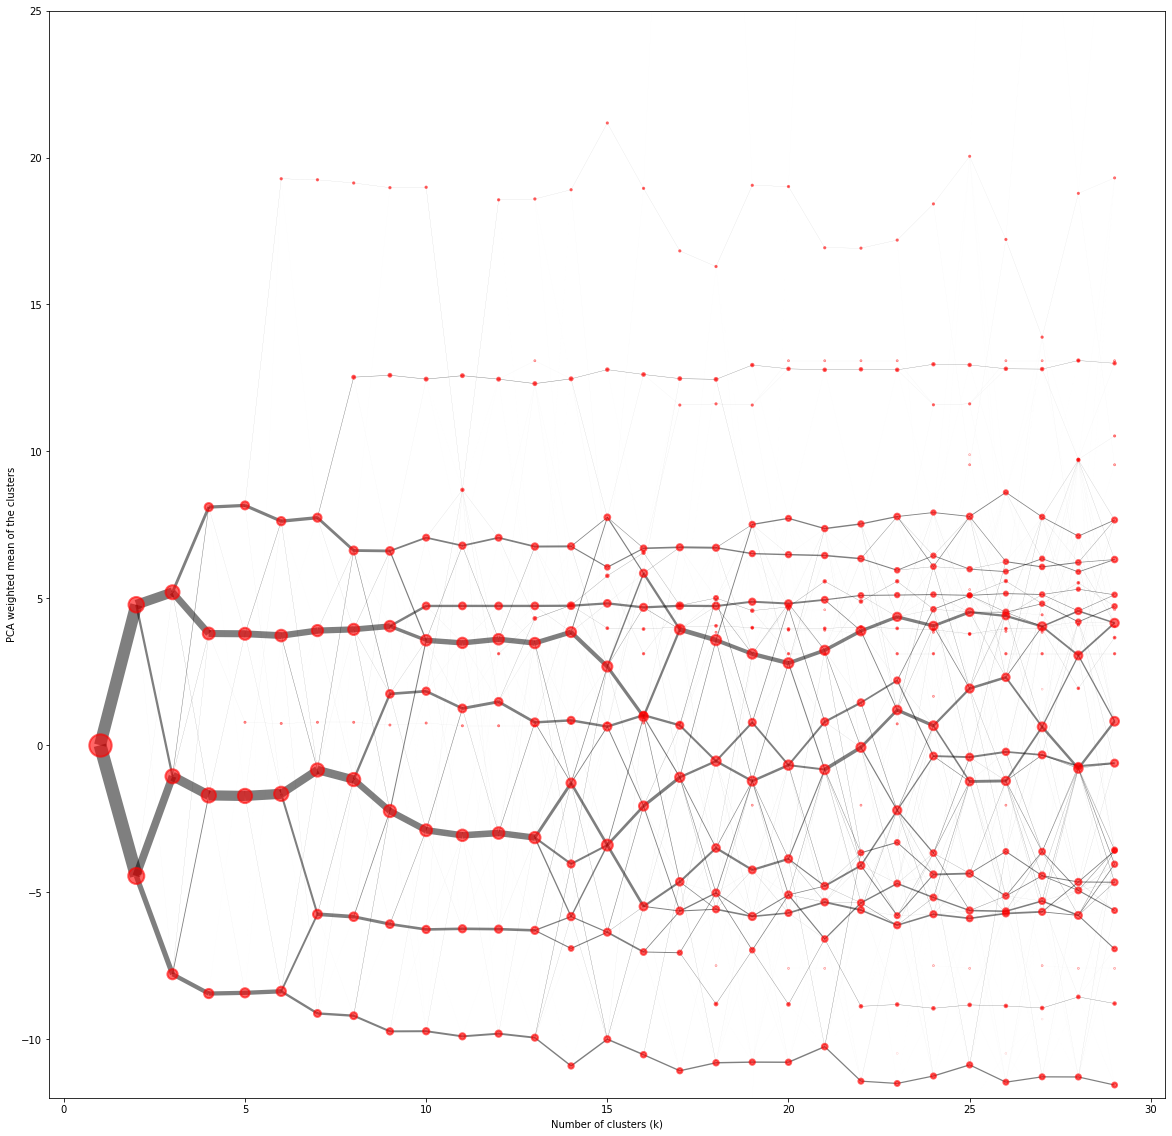

In [13]:
ax = cg_form.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-12, 25)

Based on the clustergram, we can assume that 10 clusters is the optimal number. 10 is the first point after all major branching happens and the situation stabilizes.

Before proceeding, we also save clustergam object to a file.

In [11]:
with open(folder + 'clustergram_form.pickle','wb') as f:
    pickle.dump(cg_form, f)

Let's see how 10 clusters based on form look like spatially.

In [16]:
tess['clusters_form'] = cg_form.labels[10].values

We can plot the labels based on tessellation or based on buildings, each providing different insights.

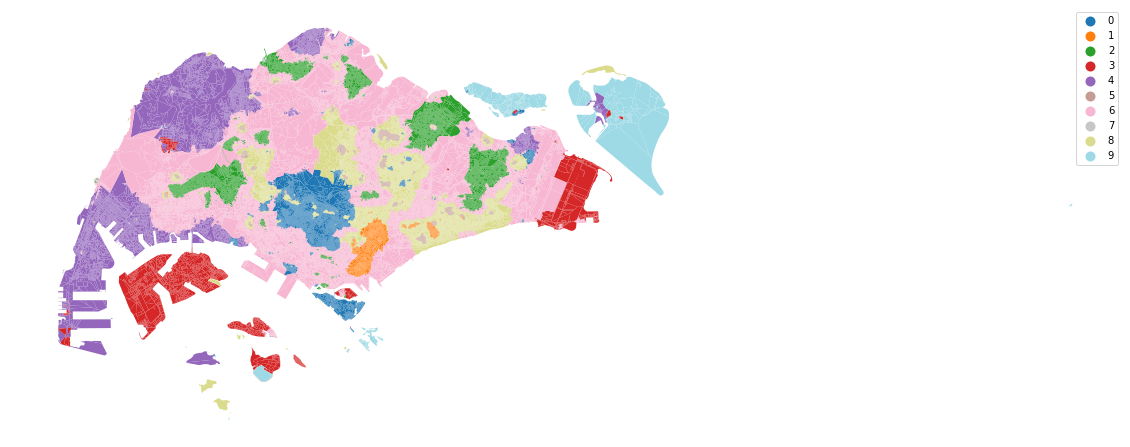

In [17]:
ax = tess.plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

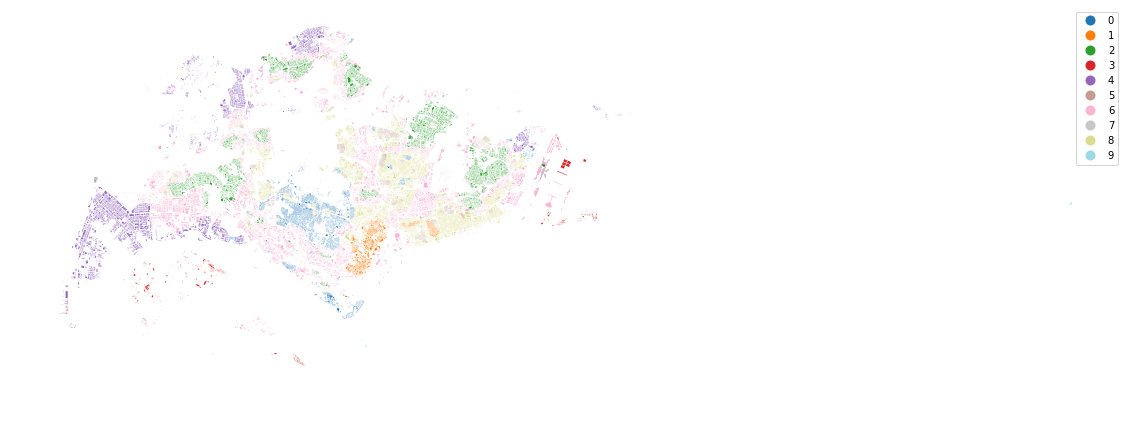

In [18]:
ax = tess.set_geometry('buildings').plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.2. Function

Clustering based on function uses only data on function, which we need to prepare.

In [21]:
function_data = pd.read_parquet(folder + "func_data_tess.pq")

We have some categorical values, so we have to encode them as boolean dummies.

In [22]:
use = pd.get_dummies(function_data.use)

Continuous values need to be standardized.

In [23]:
scaler = preprocessing.StandardScaler()
f_data = scaler.fit_transform(function_data.drop(columns=["use"]))

In [24]:
f_data.shape

(134922, 8)

We can all merge back together.

In [25]:
f_data = np.hstack([f_data, use.values])

In [26]:
f_data.shape

(134922, 14)

In [27]:
np.isnan(f_data).any().any()

False

We are using clustergram again.

In [28]:
cg_function = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_function.fit(f_data)

K=1 fitted in 0.7764382362365723 seconds.
K=2 fitted in 1.4144949913024902 seconds.
K=3 fitted in 1.984039545059204 seconds.
K=4 fitted in 2.1764419078826904 seconds.
K=5 fitted in 2.003382444381714 seconds.
K=6 fitted in 2.511932134628296 seconds.
K=7 fitted in 2.0420327186584473 seconds.
K=8 fitted in 2.3307690620422363 seconds.
K=9 fitted in 2.8213562965393066 seconds.
K=10 fitted in 3.869300365447998 seconds.
K=11 fitted in 3.4408762454986572 seconds.
K=12 fitted in 3.74088454246521 seconds.
K=13 fitted in 4.74127197265625 seconds.
K=14 fitted in 5.3450047969818115 seconds.
K=15 fitted in 5.65937066078186 seconds.
K=16 fitted in 5.548888444900513 seconds.
K=17 fitted in 6.886349201202393 seconds.
K=18 fitted in 8.079010963439941 seconds.
K=19 fitted in 9.080941915512085 seconds.
K=20 fitted in 8.3546781539917 seconds.
K=21 fitted in 10.599517345428467 seconds.
K=22 fitted in 12.19663143157959 seconds.
K=23 fitted in 13.285515546798706 seconds.
K=24 fitted in 12.042384386062622 seco

(-3.0, 8.0)

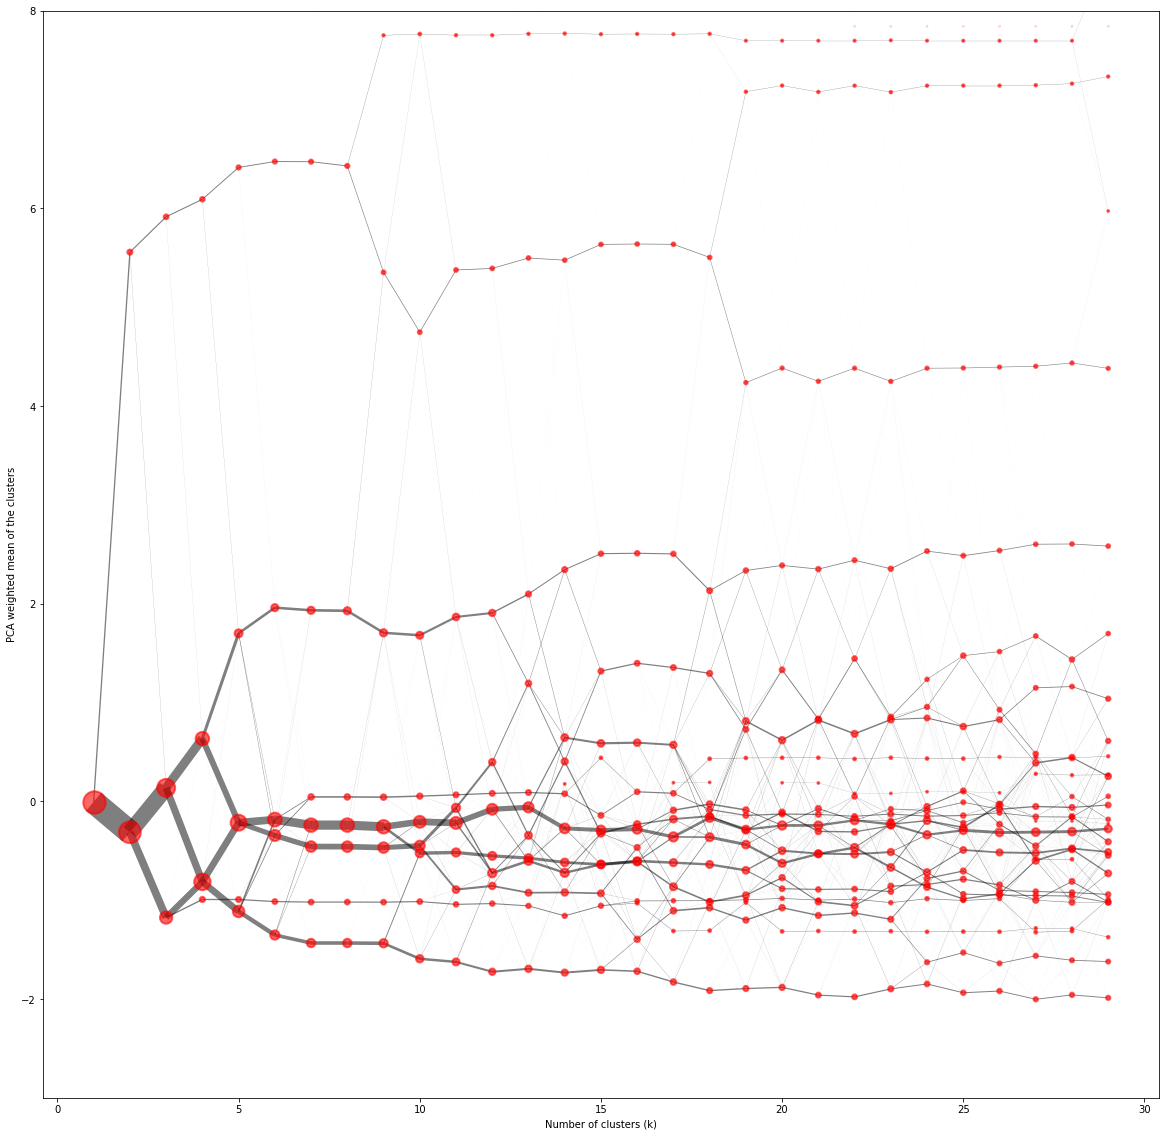

In [31]:
ax = cg_function.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-3, 8)

Clustergram should be saved to a file.

In [30]:
with open(folder + 'clustergram_function.pickle','wb') as f:
    pickle.dump(cg_function, f)

We can interpret the diagram as 9 clusters being the optimum.

The figures below show 9 clusters.

In [32]:
tess['clusters_function'] = cg_function.labels[9].values

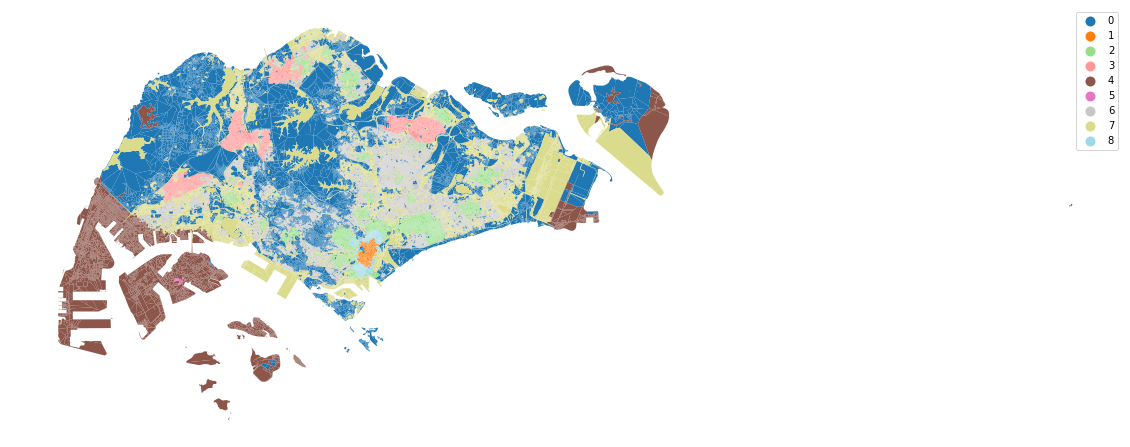

In [33]:
ax = tess.plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

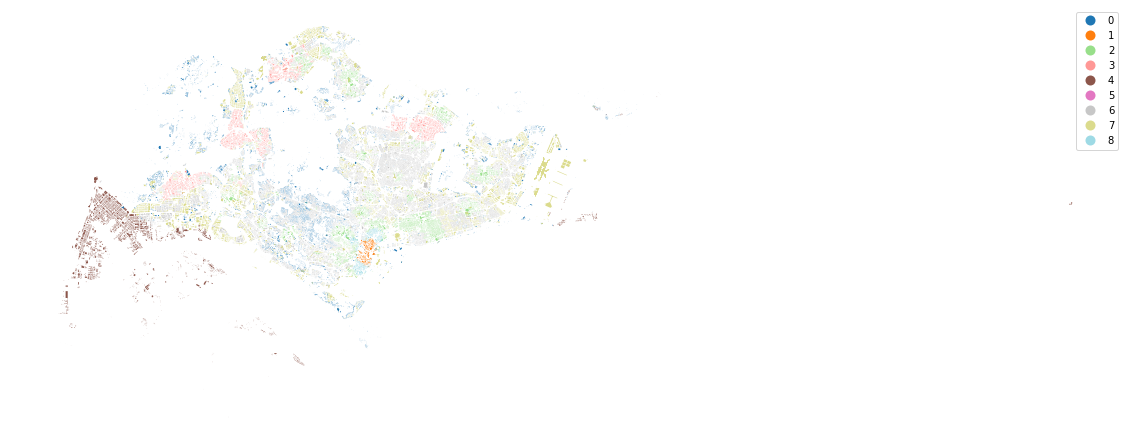

In [34]:
ax = tess.set_geometry('buildings').plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.3. Spatial Signatures

Final clustering combines both form and function into a singular classification.

First we stack both preprocessed arrays together and then run clustergram.

In [35]:
ss_data = np.hstack([data, f_data])

In [36]:
cg_ss = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_ss.fit(ss_data)

K=1 fitted in 1.2591218948364258 seconds.
K=2 fitted in 2.2755961418151855 seconds.
K=3 fitted in 3.0549662113189697 seconds.
K=4 fitted in 3.7564198970794678 seconds.
K=5 fitted in 4.678791522979736 seconds.
K=6 fitted in 4.929872751235962 seconds.
K=7 fitted in 7.506360054016113 seconds.
K=8 fitted in 7.673715829849243 seconds.
K=9 fitted in 8.514847040176392 seconds.
K=10 fitted in 9.035099267959595 seconds.
K=11 fitted in 9.754722118377686 seconds.
K=12 fitted in 9.858472347259521 seconds.
K=13 fitted in 12.23591136932373 seconds.
K=14 fitted in 14.329404592514038 seconds.
K=15 fitted in 15.388853311538696 seconds.
K=16 fitted in 14.817114114761353 seconds.
K=17 fitted in 16.235864877700806 seconds.
K=18 fitted in 16.521358966827393 seconds.
K=19 fitted in 16.69776153564453 seconds.
K=20 fitted in 20.85137152671814 seconds.
K=21 fitted in 21.157763957977295 seconds.
K=22 fitted in 23.148736715316772 seconds.
K=23 fitted in 22.140355587005615 seconds.
K=24 fitted in 20.1135373115539

(-12.0, 25.0)

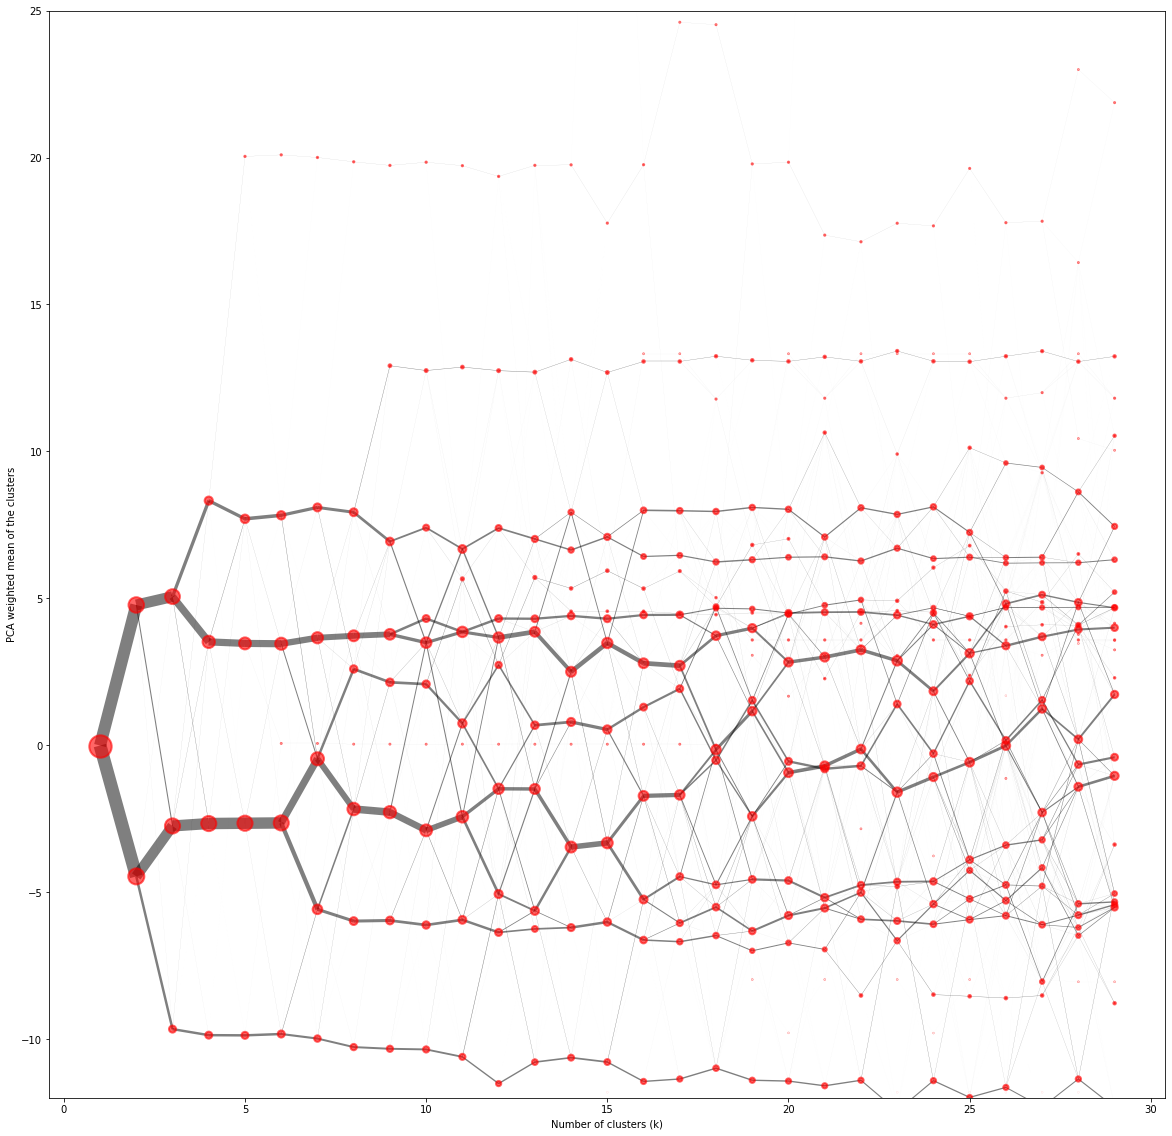

In [40]:
ax = cg_ss.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-12, 25)

In [38]:
with open(folder + 'clustergram_ss.pickle','wb') as f:
    pickle.dump(cg_ss, f)

The optimal number in this case seems to be 16 clusters. We run final clustering with 1000 initiazations and fixed random state for reproducibility.

In [45]:
%time km = KMeans(n_clusters=16, n_init=1000, random_state=12345).fit(ss_data)

CPU times: user 3h 43min 46s, sys: 1h 12min 21s, total: 4h 56min 8s
Wall time: 24min 46s


In [46]:
tess['clusters'] = km.labels_

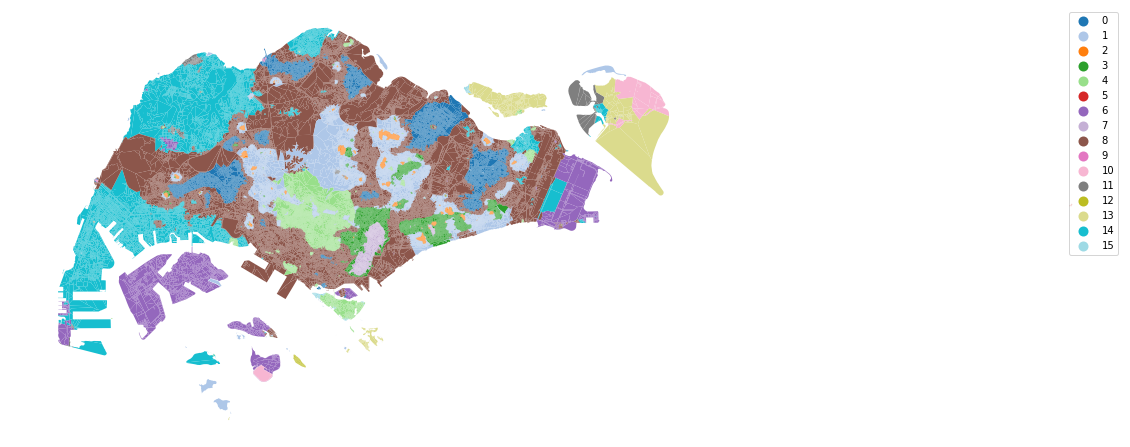

In [47]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

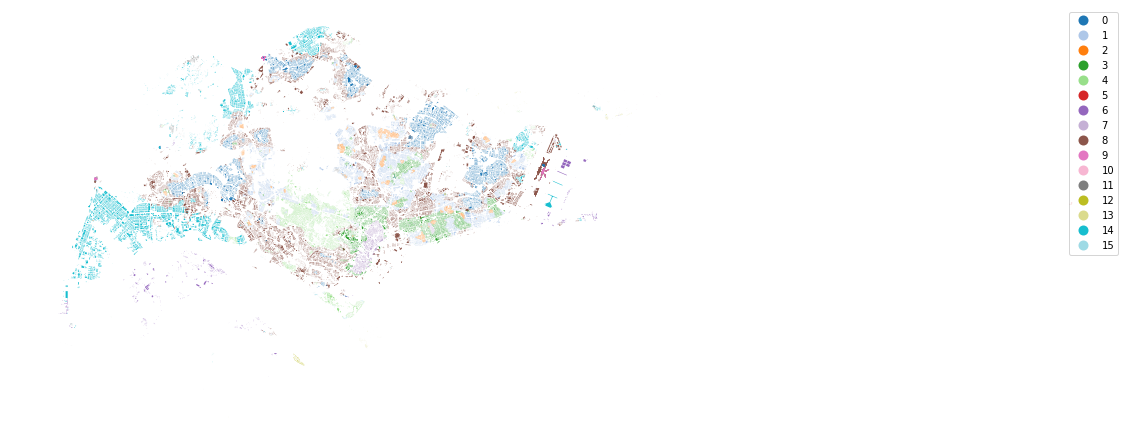

In [48]:
ax = tess.set_geometry('buildings').plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [54]:
tess[['tID', 'clusters', 'clusters_form', 'clusters_function']].to_parquet(folder + "cluster_labels.pq")
tess[['tID', 'clusters']].to_csv(folder + "FINAL_cluster_labels.csv")

#### Generate signatures

As a final step, we can generate a geometry representing spatial singatures as a combination of contiguous tessellation cells belonging to a single cluster. Since we have to dissolve a large number of polygons, we use dask_geopandas to parallelize the procedure.

First we create a local cluster.

In [2]:
client = Client(LocalCluster(n_workers=16))
client

/opt/conda/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35751 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37721 Dashboard: http://127.0.0.1:35751/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


We read only 'tessellation' columns and cluster labels. The resulting geometry will not be enclosed tessellation anymore so we can already rename it to generic "geometry".

In [3]:
tess = gpd.read_parquet(folder + "tess.pq", columns=['tessellation']).rename_geometry("geometry")
clusters = pd.read_csv(folder + "FINAL_cluster_labels.csv", index_col=0)

In [4]:
tess['cluster'] = clusters.clusters.values

`dask_dissolve` mimics the behaviour of `geopandas.dissolve`, just based on parallel implementation using `dask-geopandas`.

In [8]:
%%time
ddf = dask_geopandas.from_geopandas(tess.sort_values('cluster'), npartitions=64)
final = dask_dissolve(ddf, by='cluster').compute()

CPU times: user 1min 34s, sys: 10 s, total: 1min 44s
Wall time: 13min 58s


In [ ]:
final.plot('cluster', categorical=True, figsize=(20, 20), cmap='tab20')

Finally, we explode the geometries to get multiple singatures of the same kind instead of a single multipolygon. (The intial `reset_index` is here to avoid bug in geopandas.)

In [ ]:
final.reset_index(drop=True).explode().reset_index(drop=True).to_parquet(folder + "signatures.pq")

Before we end, we close dask client.

In [16]:
client.close()

# 4. Figures

Finally, we create final figures.

In [ ]:
sigbn